# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откройте файл с данными и изучите общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

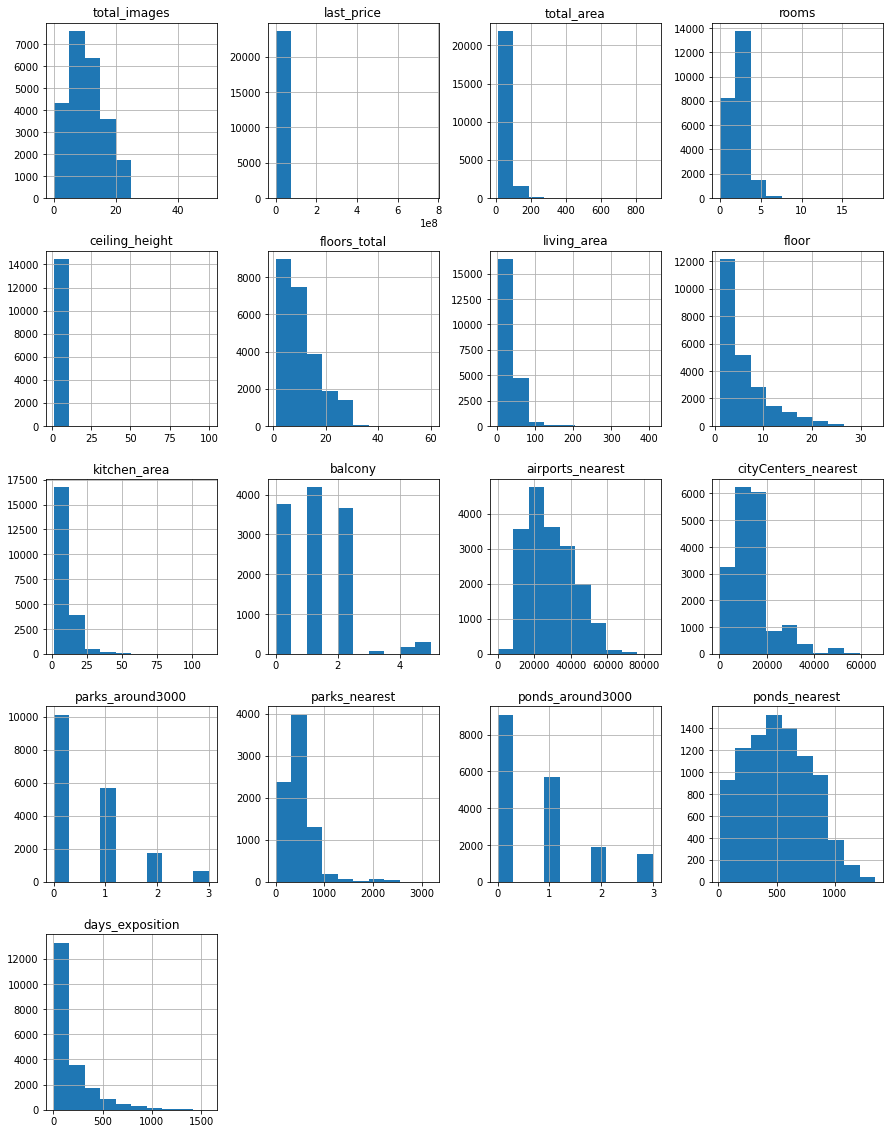

In [75]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
#data.head()
data.info()
data.hist(figsize=(15,20))
#data['last_price'].hist(bins=5)




Применив команду info(), можно сделать вывод, что таблица с данными содержит 23699 объявлений.
Некоторые записи содержат пустые значения(например высота потолков, жилая площадь...) Работу с ними проведу в следующем шаге. 

Также замечена странность с типом данных атрибут is_apartment. Указан object, вместо bool
Ну и по мелочи для количественных значений вроде числа этажей, числа парков и прудов тип указан float, хотя по логике должен быть целочисленным. Неверно указан тип данных для first_day_exposition.
    

Были построены гистограммы для всех показателей. По некоторым показателям уже можно делать начальные выводы, например: чаще всего в объявлении размещают 5-15 фотографий.
Для определения стоимости - общая гистограмма для датафрейма ненаглядна, т.к. масштаб осей не позволяет оценить диапазон. Буду разбираться в шаге 4.


### Предобработка данных

In [76]:
#заполнение пропусков
data['is_apartment'] = data['is_apartment'].fillna('False')
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
#data['ceiling_height'].unique()
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
living_area_not_null = data.query('living_area.notnull()==True')
kitchen_area_not_null = data.query('kitchen_area.notnull()==True')
living_area_coef = data['total_area'].mean() / living_area_not_null['living_area'].mean()
kitchen_area_coef = data['total_area'].mean() / kitchen_area_not_null['kitchen_area'].mean()
data['living_area'] = data['living_area'].fillna(data['total_area'] / living_area_coef) 
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] / kitchen_area_coef) 



Заполнил очевидные пропуски в is_apartment значением False. 
Также из описания проекта указано, что число балконов будет правильно заменить на 0, что я и сделал. Аналогично поступил и с числом парков/водоёмов.

Высоту потолков посчитал параметром, пропущенные значения которого тоже можно заменить и это не сильно отразится на дальнейшем анализе. Просмотрев уникальные значения, увидел выбросы в 20, 100 метров. Поэтому выбрал заполнение медианой, а не средним значением.    
    
Пропуски в остальных значениях трогать не стал, т.к. считаю, что в данных о жилой площади и площади кухни не получится заполнить достоверной информацией. В столбцах, например floors_total и locality_name их значение невелико. А столбцы с удаленностью квартиры от парков, водоемов и аэропортов зачастую не являются ключевыми для принятия решения о покупке недвижимости. Поэтому ими пренебрег

In [77]:
#изменение типов данных
data['last_price'] = data['last_price'].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')
#data['floors_total'] = data['floors_total'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')


In [78]:
#устранение неявных дубликатов
data['locality_name'] = data['locality_name'].str.replace('посёлок ','')
data['locality_name'] = data['locality_name'].str.replace('городской ','')
data['locality_name'] = data['locality_name'].str.replace('деревня ','')
data['locality_name'] = data['locality_name'].str.replace('городского типа ','')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа ','')
data['locality_name'] = data['locality_name'].str.replace('поселок ','')
data['locality_name'] = data['locality_name'].str.replace('село ','')
data['locality_name'] = data['locality_name'].str.replace('коттеджный ','')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество ','')
data['locality_name'] = data['locality_name'].str.replace('станции ','')
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной ','')
data['locality_name'] = data['locality_name'].str.replace('имени ','')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество ','')
#data['locality_name'].unique()



Убрал наименования нас.пунктов(деревня, поселок и.т.п.) Методом unique() проверил итоговый результат

<AxesSubplot:>

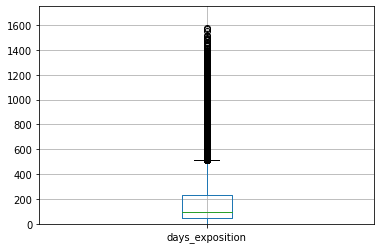

In [79]:
# устранение аномалий
data.query('last_price < 100000')
data['last_price'] = data['last_price'].replace(12190,12190000)
data['rooms'].unique()
data['rooms'] = data['rooms'].replace(0,1)

#data['ceiling_height'].unique()
data.query('ceiling_height < 2 | ceiling_height > 6').sort_values(by='ceiling_height')

data.loc[(data.ceiling_height >= 25) & (data.ceiling_height <100), 'ceiling_height'] = data['ceiling_height'] / 10

#data.query('total_area > 200 & living_area < 50 ')
#data.query('floors_total < floor')
#data.query('total_area < living_area | total_area < kitchen_area')
data.query('balcony / rooms > 3')

data = data.query('ceiling_height >= 2 & ceiling_height < 8 & balcony / rooms < 3')
import matplotlib.pyplot as plt 
plt.ylim(0, 1750)
data.boxplot(column = 'days_exposition')





Для начала определил, есть ли цены менее 100000, потому что встречал объявления, где люди указывают цену в т.р., а там уж покупатель догадается.

Далее скорректировал записи с количеством комнат=0 на 1
   
Проверил записи с очень низкими и очень высокими потолками. Скорректировал там, где возможно.

Затем стал проверять наличие записей, где общая площадь меньше жилой, либо кухни. Отбросил записи, где приходится более 2-х балконов на одну комнату
    
Спорный момент с числом дней, которое висело объявление. Диаграмма размаха показывает множество "выбросов", с другой стороны пользователь мог возвращать одно и то же объявление. Например, если передумал продавать, затем опять решил спустя какое-то время продать квартиру. Было принято решение не трогать такие случаи.
    

### Посчитайте и добавьте в таблицу новые столбцы

In [80]:
data['price_metr'] = data['last_price'] / data['total_area']
data['date_day'] = data['first_day_exposition'].dt.weekday
data['date_month'] = data['first_day_exposition'].dt.month
data['date_year'] = data['first_day_exposition'].dt.year

def floors(row):
    try:
        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except:
        return 'ошибка'
    
data['floors_type'] = data.apply(floors,axis=1)
data['city_center_km'] = data['cityCenters_nearest'] / 1000
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr,date_day,date_month,date_year,floors_type,city_center_km
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,16.028
1,7,3350000,40.40,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый,18.603
2,10,5196000,56.00,2015-08-20,2,2.65,5.0,34.300000,4,True,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,13.933
3,0,64900000,159.00,2015-07-24,3,2.65,14.0,90.785766,9,True,...,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой,6.800
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой,8.098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.300000,3,True,...,796.0,3,381.0,NaN,72490.845228,1,3,2017,другой,4.232
23695,14,3100000,59.00,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,0,NaN,45.0,52542.372881,0,1,2018,другой,NaN
23696,18,2500000,56.70,2018-02-11,2,2.65,3.0,29.700000,1,True,...,NaN,0,NaN,NaN,44091.710758,6,2,2018,первый,NaN
23697,13,11475000,76.75,2017-03-28,2,3.00,17.0,43.822689,12,True,...,173.0,3,196.0,602.0,149511.400651,1,3,2017,другой,10.364


### Проведите исследовательский анализ данных

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'first_day_exposition'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>],
       [<AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>],
       [<AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>,
        <AxesSubplot:title={'center':'days_exposition'}

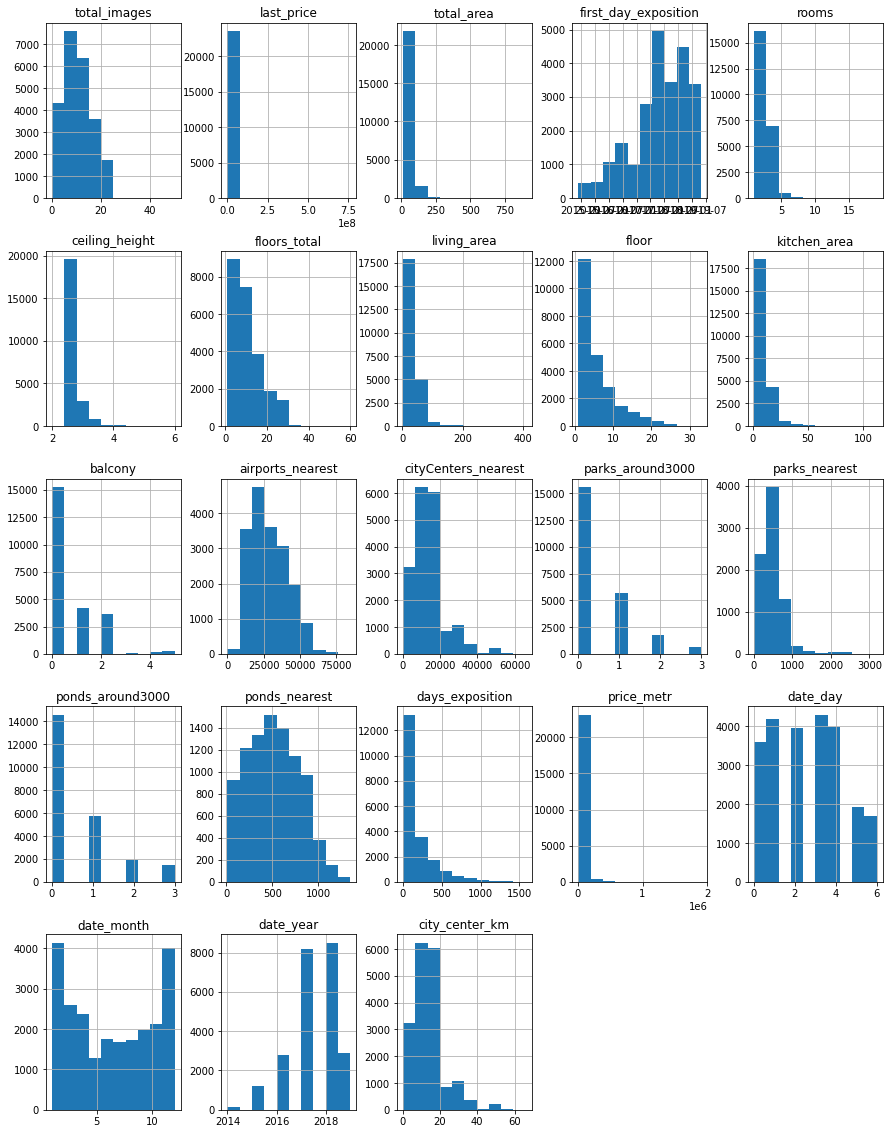

In [81]:
data.hist(figsize=(15,20))


In [82]:
data['total_area'].describe()

count    23644.000000
mean        60.381636
std         35.683764
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

In [83]:
data['living_area'].describe()

count    23644.000000
mean        34.620527
std         22.369500
min          2.000000
25%         19.000000
50%         30.000000
75%         42.200000
max        409.700000
Name: living_area, dtype: float64

In [84]:
data['kitchen_area'].describe()

count    23644.000000
mean        10.506096
std          6.045202
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [85]:
data['last_price'].describe()

count    2.364400e+04
mean     6.544391e+06
std      1.089663e+07
min      4.300000e+05
25%      3.403750e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [86]:
data['rooms'].describe()

count    23644.000000
mean         2.081078
std          1.066292
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [87]:
data['ceiling_height'].describe()

count    23644.000000
mean         2.696843
std          0.221192
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64

In [88]:
data['floor'].describe()

count    23644.000000
mean         5.888175
std          4.882792
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

In [89]:
data['floors_type'].describe()

count      23644
unique         3
top       другой
freq       17402
Name: floors_type, dtype: object

In [90]:
data['floors_total'].describe()

count    23558.000000
mean        10.670770
std          6.596608
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [91]:
data['cityCenters_nearest'].describe()

count    18138.000000
mean     14189.568310
std       8608.469105
min        181.000000
25%       9238.000000
50%      13096.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [92]:
data['airports_nearest'].describe()

count    18115.000000
mean     28788.191720
std      12630.844098
min          0.000000
25%      18582.000000
50%      26721.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [93]:
data['parks_nearest'].describe()

count    8062.000000
mean      490.769660
std       342.333381
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

        
Описал параметры методом describe. Средняя площадь продаваемых квартир = 60 м2. Максимальная площадь, указанная в объявлении составляла 900 м2. Средняя и медианная стоимость квартир сопоставимы и составляют около 4,3 и 4,65 млн. соответственно.
В большинстве случаев продают квартиры на 4 этаже, а общее число этаж в большинстве случаев = 9
Из курса мы проходили только нормальное распределение и распределение Пуассона. Нормальному распределнию соответствует гистограмма с числом фотографий, а также продажи по дням неделям
        

count    20468.000000
mean       180.906097
std        219.736199
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

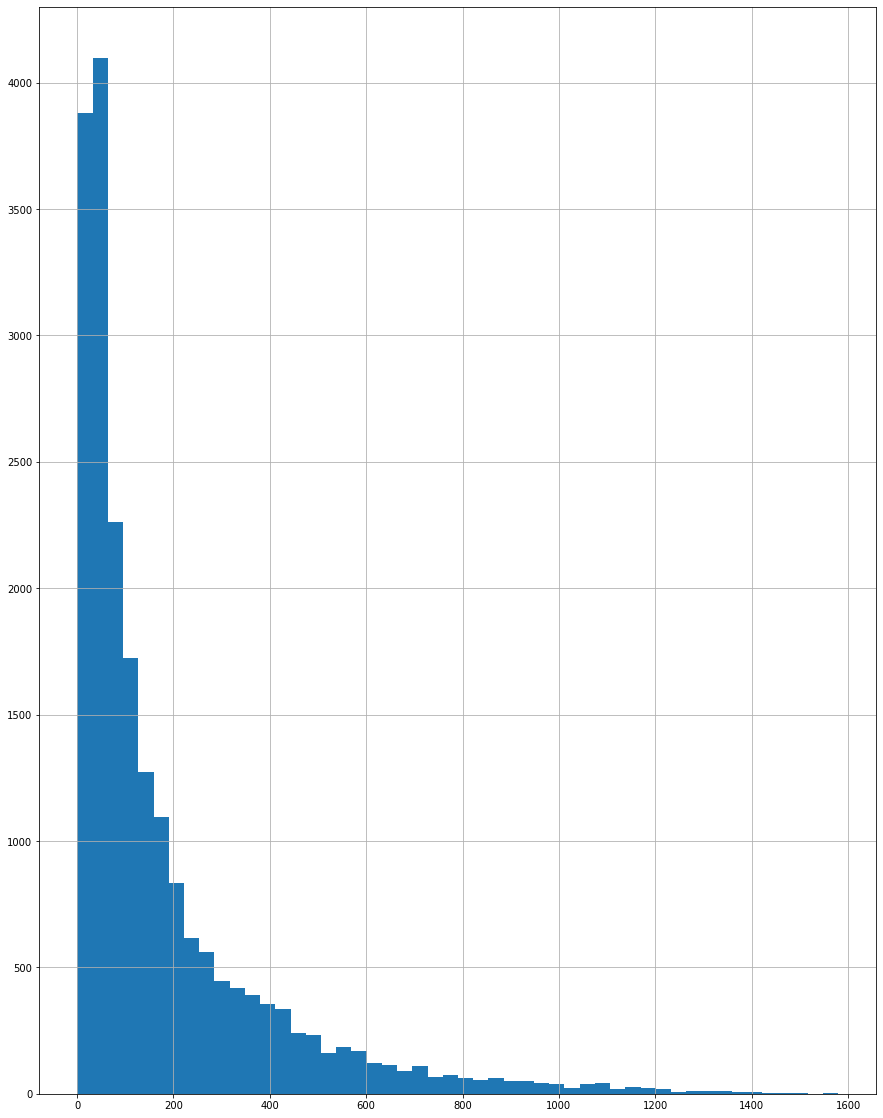

In [94]:
data['days_exposition'].hist(figsize=(15,20),bins=50)
data['days_exposition'].describe()

<AxesSubplot:>

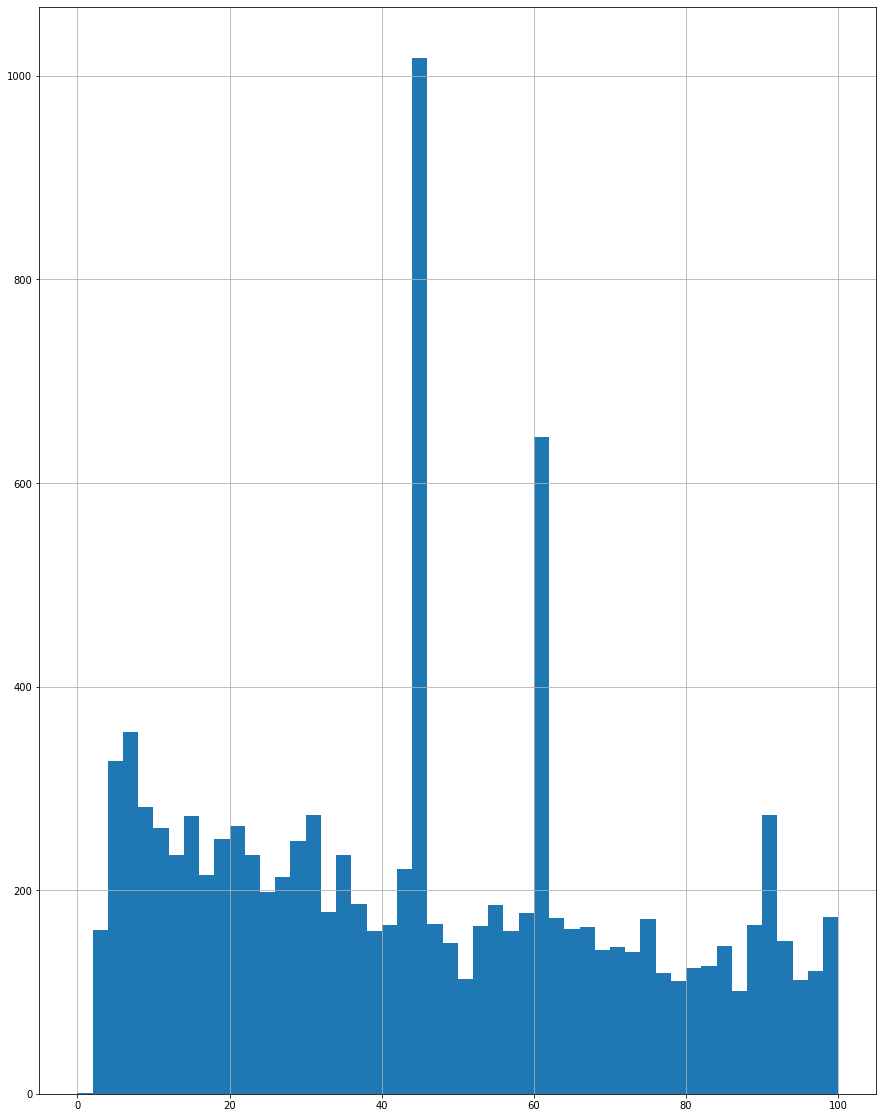

In [95]:
data['days_exposition'].hist(figsize=(15,20),bins=50, range = (0,100))



Большинство квартир продается за 95 дней(медианное значение). Быстрой можно считать продажу до 45 дней( 1-й квартиль). 
Аномально долгими можно считать продажи свыше 500 дней.

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

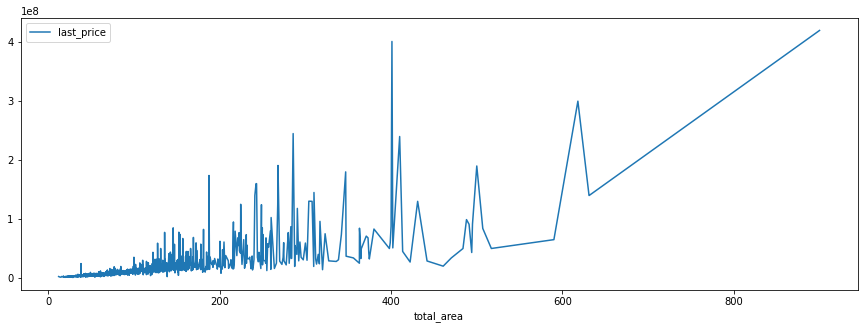

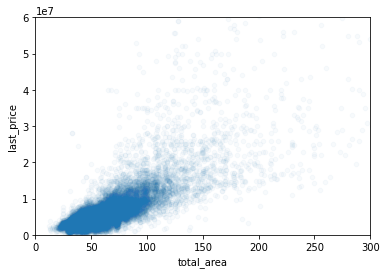

In [96]:
(
    data.pivot_table(index='total_area', values='last_price', aggfunc='median')
    .plot(figsize=(15, 5) )
)    
data.plot(x = 'total_area', y = 'last_price', kind='scatter', alpha=0.03, xlim = (0,300), ylim = (0,60000000))


<AxesSubplot:xlabel='living_area', ylabel='last_price'>

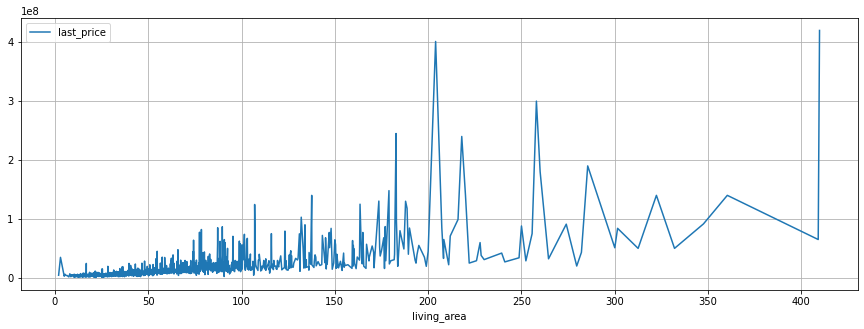

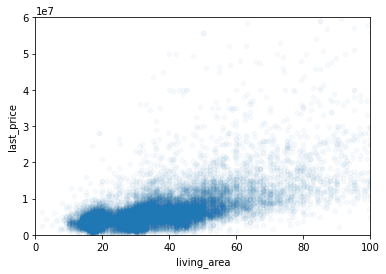

In [97]:
(
    data.pivot_table(index='living_area', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(15, 5))
)  

data.plot(x = 'living_area', y = 'last_price', kind='scatter', alpha=0.03, xlim = (0,100), ylim = (0,60000000))


<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

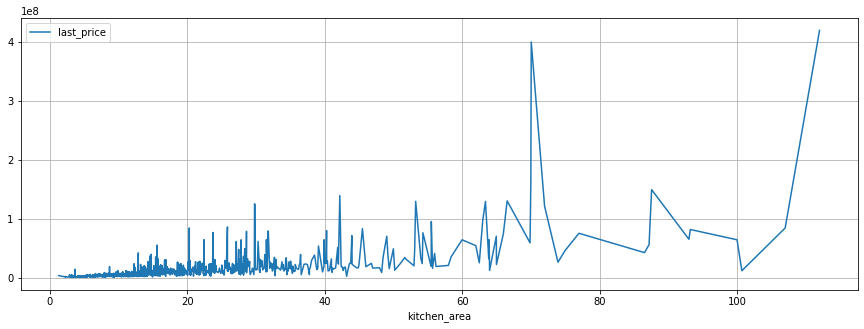

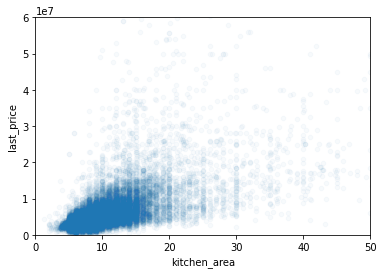

In [98]:
(
    data.pivot_table(index='kitchen_area', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(15, 5))
)   

data.plot(x = 'kitchen_area', y = 'last_price', kind='scatter', alpha=0.03, xlim = (0,50), ylim = (0,60000000))


<AxesSubplot:xlabel='rooms', ylabel='last_price'>

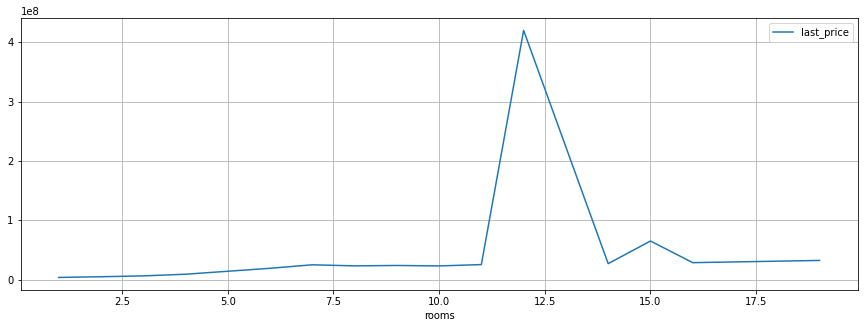

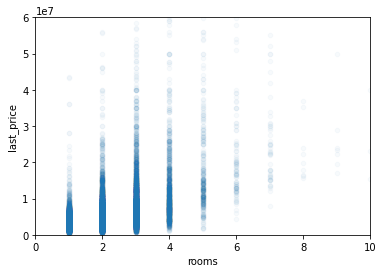

In [99]:
(
    data.pivot_table(index='rooms', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(15, 5))
) 

data.plot(x = 'rooms', y = 'last_price', kind='scatter', alpha=0.03, xlim = (0,10), ylim = (0,60000000))


<AxesSubplot:xlabel='floors_type', ylabel='last_price'>

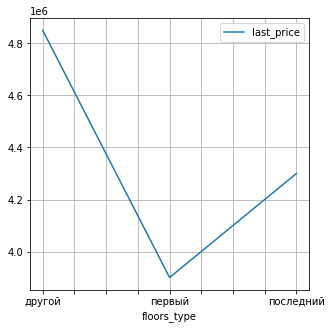

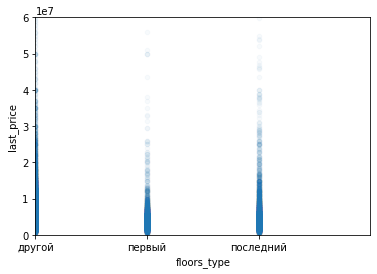

In [100]:
(
    data.pivot_table(index='floors_type', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(5, 5))
) 
data.plot(x = 'floors_type', y = 'last_price', kind='scatter', alpha=0.03, xlim = (0,3), ylim = (0,60000000))


<AxesSubplot:xlabel='date_year'>

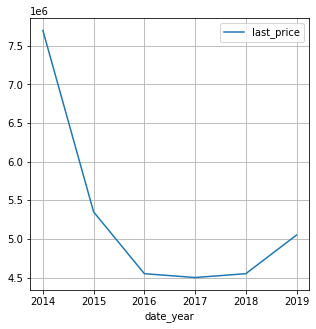

In [101]:
(
    data.pivot_table(index='date_year', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(5, 5))
) 

<AxesSubplot:xlabel='date_month'>

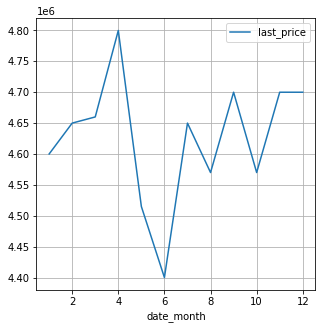

In [102]:
(
    data.pivot_table(index='date_month', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(5, 5))
) 

<AxesSubplot:xlabel='date_day'>

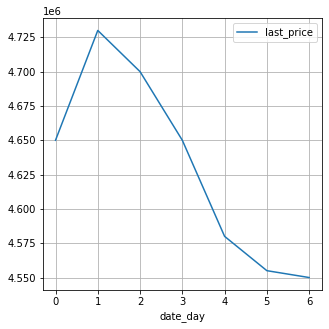

In [103]:
(
    data.pivot_table(index='date_day', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(5, 5))
) 



Была изучена зависимость стоимости от указанных параметров. Чем больше площадь(общая,жилая, кухни), тем выше цена.
Также наблюдается прямая зависимость стоимости от количества комнат.

В разбивке по годам видно, что больше всего продавалось квартир в 2014 году, далее тренд пошел на спад, а с 2018 года снова пошел вверх.

Самый массовый по объему продаж месяц - апрель. Июнь наоборот. Месяц, когда число продаж минимально.

По дням недели пик продаж приходится на вторник. Пятница, суббота и воскресенье дни с минимальным объемом продаж. 

In [104]:
top_price_m = data.pivot_table(index='locality_name', values='price_metr', aggfunc=['mean', 'count']) 
top_price_m.columns = ['price','count']
top_price_m.sort_values(by = 'count', ascending= False).head(10)

,price,count
locality_name,,
Санкт-Петербург,114781.706762,15684
Мурино,86072.016295,586
Кудрово,95343.695818,471
Шушары,78717.065439,439
Всеволожск,68654.473986,398
Пушкин,103125.819291,369
Колпино,75424.579098,338
Парголово,90175.913458,327
Гатчина,68746.146763,307


In [105]:
data['locality_name'].loc[data['price_metr'] == max(data['price_metr'])]


12971    Санкт-Петербург
Name: locality_name, dtype: object

In [106]:
data['locality_name'].loc[data['price_metr'] == min(data['price_metr'])]


14911    Свирь
Name: locality_name, dtype: object

In [107]:
spb_data = data.query('locality_name == "Санкт-Петербург"')

<AxesSubplot:xlabel='cityCenters_nearest'>

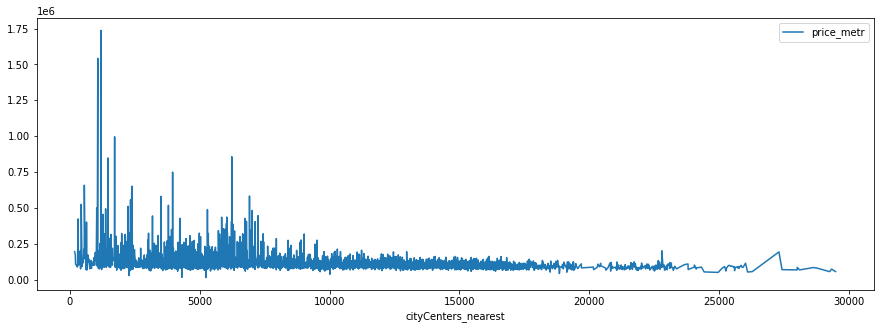

In [108]:
spb_data.pivot_table(index='cityCenters_nearest', values='price_metr', aggfunc='mean') .plot(figsize=(15,5))



    
На графике видно, что стоимость квартиры зависит от удаленности от центра. Чем ближе к центру жилье, тем дорожеНа стоимость жилья также влияет удаленность от центра.
    


        
Был изучен файл со статистикой объявлений о продаже недвижимости в СПб и Ленинградской области. Выявлена зависимость между стоимостью квартир и площадью. На стоимость жилья также влияет удаленность от центра.
Самые дорогие квартиры продаются в Санкт-Петербурге. В среднем, продажа квартиры занимает около 95 дней. 
В рассматриваемом периоде, наибольшая стоимость недвижимости пришлась на 2014 год.
